# HW_4:Симуляция распространения болезни. Работа с NetworkX.

### Цель: смоделировать распространение инфекции по международной сети аэропортов, увидеть, как заражение аэропортов-хабов приводит к взрывному росту заболеваний и создать свой локальный Plague Inc.,

Описание/Пошаговая инструкция выполнения домашнего задания: \
Набор данных представляет собой основные маршруты авиаперелетов в США за один месяц 2008-го года. В качестве модели распространения инфекции предлагается использовать SI (susceptible-infected) модель, в которой каждый аэропорт имеет два возможных состояния - “здоровый” или “зараженный”. Здоровый аэропорт может заразиться с некоторой вероятностью p (infection probability), если к нему прилетает самолет из зараженного города. Инфекция начинает распространение из некоторого стартового аэропорта и заканчивает распространение, когда все перелеты из датасета завершены.

Часть 1. Пишем симуляцию. \
Напишите функцию для симуляции одного прохода по всему датасету и распространения инфекции. Функция должна принимать на вход стартовый город, в котором изначально началась инфекция и вероятность распространения инфекции p. На выходе функция должна возвращать словарь, в котором ключом будет время заражения аэропорта, значением - название аэропорта. В теле функции вам нужно написать проход по всему датасету (имеет смысл использовать itertuples), где вы будете проверять, является ли текущий рейс “заразным” и если да - с вероятностью p заражать новый аэропорт. \
В качестве стартовой ноды/аэропорта для симуляций можно использовать Allentown (node_id = 0).

Часть 2. Как инфекционность (вероятность заражения) болезни влияет на скорость распространения? \
Давайте посмотрим, насколько заразной должна быть болезнь, чтобы заразить все аэропорты в сети. Для каждой из вероятностей p=[0.01, 0.05, 0.1, 0.5, 1.] прогоните по 10 симуляций распространения, каждый раз сохраняя результаты.
Для каждых 12 часов симуляции посчитайте, какой средний процент аэропортов от общего их числа, был заражен к этому моменту времени. Постройте графики числа зараженных городов в зависимости от времени для каждой из вероятностей.

Часть 3. Может ли информация о сети помочь предсказать, кто будет заражен?\
Настало время поработать с NetworkX.
3.1.По имеющемуся датасету вам нужно построить ненаправленный граф всех аэропортов, используя относительное число перелетов между соседними аэропортами в качестве веса ребра. Например, если из аэропорта А в аэропорт Б суммарно есть 5 рейсов, из Б в А 10 рейсов, а всего в сети 150 перелетов, то вес ребра между А и Б должен быть равен (5+10)/150 = 0.1.
3.2.Прогоните вашу симуляцию 50 раз, используя p=0.5 и стартовый аэропорт Allentown, каждый раз сохраняя результаты. Используя данные симуляций посчитайте медианное время до заражения каждого города.
3.3.Теперь используя построенный вами граф, для каждого города посчитайте его коэффициент кластеризации (nx.clustering), степень (nx.degree) и центральность (nx.betweenness_centrality).
3.4.Наконец, постройте scatter-plot-ы для медианного времени заражения и каждой из рассчитанных выше метрик. Также посчитайте коэффициент корреляции Спирмана между этими показателями и попробуйте проинтерпретировать полученные результаты. Какая из метрик графа сильнее всего скоррелирована со временем заражения? Почему?
https://www.kaggle.com/datasets/vikalpdongre/us-flights-data-2008

In [45]:
import numpy as np
import pandas as pd
import math

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import networkx as nx
from collections import defaultdict
from tqdm.auto import tqdm
from datetime import datetime, timedelta

import networkx as nx
from scipy.stats import spearmanr
import random

# 1. Препроцессинг

In [46]:
df = pd.read_csv('2008.csv')
df.head(3)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [47]:
df.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

### Оставим колонки, содержащие время отправления и прибытия, а также пункты отправления и назначения.

In [48]:
data = df[['Year', 'Month', 'DayofMonth', 'Origin', 'CRSDepTime', 'Dest', 'CRSArrTime']]
data.head(3)

,Year,Month,DayofMonth,Origin,CRSDepTime,Dest,CRSArrTime
0,2008,1,3,IAD,1955,TPA,2225
1,2008,1,3,IAD,735,TPA,1000
2,2008,1,3,IND,620,BWI,750


In [49]:
# Функция преобразования времени к формату 12:34
def get_time(time):

    str_time = str(time).rjust(4, '0')
    return str_time[:2] + ':' + str_time[2:]

In [50]:
# Функция для преобразования к формату datetime
@np.vectorize
def get_datetime(year, month, day, time):

    h, m = time.split(sep=':')
    result = datetime(year, month, day, int(h), int(m))
    return result

In [54]:
# Подготовка датасета
def prepare(data):

  # Заменяем 24:00 на 23:59
    data.loc[data['CRSArrTime'] >= 2400, 'CRSArrTime'] = 2359
    data.loc[data['CRSDepTime'] >= 2400, 'CRSArrTime'] = 2359

  # Создаём колонки с временем вылета и прибытия
    data['Arr_time'] = data['CRSArrTime'].apply(get_time)
    data['Dep_time'] = data['CRSDepTime'].apply(get_time)

  # Создаём колонки datetime
    data['start_time'] = get_datetime(data['Year'], data['Month'], data['DayofMonth'], data['Dep_time'])
    data['end_time'] = get_datetime(data['Year'], data['Month'], data['DayofMonth'], data['Arr_time'])

  # Оставим только то, что нужно для моделирования
    result = data[['start_time', 'Origin', 'end_time', 'Dest']]

  # Корректируем время, если прилёт на следующий день
    result.loc[result['start_time'] > result['end_time'], 'end_time'] += timedelta(hours=24)

  # Делаем сортировку по времени вылета
    result.sort_values('start_time', inplace=True)

    return result

In [55]:
print(type('start_time'))
print(type('end_time'))

<class 'str'>
<class 'str'>


In [56]:
data = prepare(data)
data.head()

,start_time,Origin,end_time,Dest
428607,2008-01-01 00:10:00,LAX,2008-01-01 07:37:00,DTW
546846,2008-01-01 00:15:00,SMF,2008-01-01 08:23:00,JFK
588019,2008-01-01 00:25:00,PHX,2008-01-01 07:09:00,JFK
488832,2008-01-01 00:25:00,SMF,2008-01-01 05:35:00,DFW
428051,2008-01-01 00:30:00,LAX,2008-01-01 06:05:00,MSP


In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1436054 entries, 428607 to 1328680
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   start_time  1436054 non-null  datetime64[ns]
 1   Origin      1436053 non-null  object        
 2   end_time    1436054 non-null  datetime64[ns]
 3   Dest        1436053 non-null  object        
dtypes: datetime64[ns](2), object(2)
memory usage: 54.8+ MB


In [59]:
# Из всего датасета возьмём только один месяц с 2008-01-01 по 2008-01-31
split_date = '2008-02-01'
data = data[data.end_time < split_date].copy()

data.to_csv('2008_short.csv', index=False)

In [60]:
data = pd.read_csv('2008_short.csv')
data.head(2)

,start_time,Origin,end_time,Dest
0,2008-01-01 00:10:00,LAX,2008-01-01 07:37:00,DTW
1,2008-01-01 00:15:00,SMF,2008-01-01 08:23:00,JFK


In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605369 entries, 0 to 605368
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   start_time  605369 non-null  object
 1   Origin      605369 non-null  object
 2   end_time    605369 non-null  object
 3   Dest        605369 non-null  object
dtypes: object(4)
memory usage: 18.5+ MB


# 2. Симуляция распространения инфекции - один проход по датасету

In [64]:
# Задаем точку отсчета времени распространения инфекции
init_datetime = get_datetime([2008], [1], [1], ['00:00'])[0]

In [70]:
def get_simulation(airport, p):
    infected = [airport]
    results = {airport: init_datetime}

    for row in tqdm(data.itertuples()):
        chance = np.random.uniform()
        if (row.Origin in infected) and (row.Dest not in infected) and chance <= p:
            infected.append(row.Dest)
            results[row.Dest] = row.end_time
        else:
            continue
    return results

In [71]:
N = len(data['Origin'].unique())
p = 0.001
airport = 'ABE'
print('Starting airport:', airport)
np.random.seed(42)
res = get_simulation(airport, p)
print(f'Infected in a month: {len(res)}/{N}')

Starting airport: ABE


0it [00:00, ?it/s]

Infected in a month: 1/286


# 3.Как вероятность заражения влияет на скорость распространения?

In [72]:
def run_simulations(airport, prob, n):
    results = pd.DataFrame(columns=['p', 'sim_id', 'airport', 'infected'])
    for p in prob:
        print(f'Simulation for p = {p}')
        for sim in tqdm(range(n)):

            sim_res = pd.DataFrame.from_dict(get_simulation(airport, p), orient='index').reset_index()
            sim_res.columns = ['airport', 'infected']
            sim_res['sim_id'] = sim
            sim_res['p'] = p
            results = pd.concat([results, sim_res])

    return results

In [73]:
prob = [0.01, 0.05, 0.1, 0.5, 1]
n = 10
np.random.seed(42)
print('Starting airport:', airport)
results_df = run_simulations(airport, prob, n)
results_df.to_pickle('results_sim.pkl')

Starting airport: ABE
Simulation for p = 0.01


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Simulation for p = 0.05


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Simulation for p = 0.1


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Simulation for p = 0.5


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Simulation for p = 1


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Визуализация

In [75]:
min_time = data['start_time'].min()
print(min_time)
print(type(min_time))

2008-01-01 00:10:00
<class 'str'>


In [76]:
max_time = data['end_time'].max()
print(max_time)
print(type(max_time))

2008-01-31 23:59:00
<class 'str'>


In [77]:
data['start_time'] = pd.to_datetime(data['start_time'])
data['end_time'] = pd.to_datetime(data['end_time'])

In [78]:
min_time = data['start_time'].min()
max_time = data['end_time'].max()

# Словарь для записи результата
time_sim_res = dict()

# time delta
td = timedelta(hours=12)

# time point
tp = min_time
while tp < max_time:
    infected_pct = results_df[results_df.infected <= tp].groupby(['p', 'sim_id']).size()/N
    infected_pct = infected_pct.reset_index().groupby('p')[0].mean()
    time_sim_res[tp] = infected_pct
    tp += td

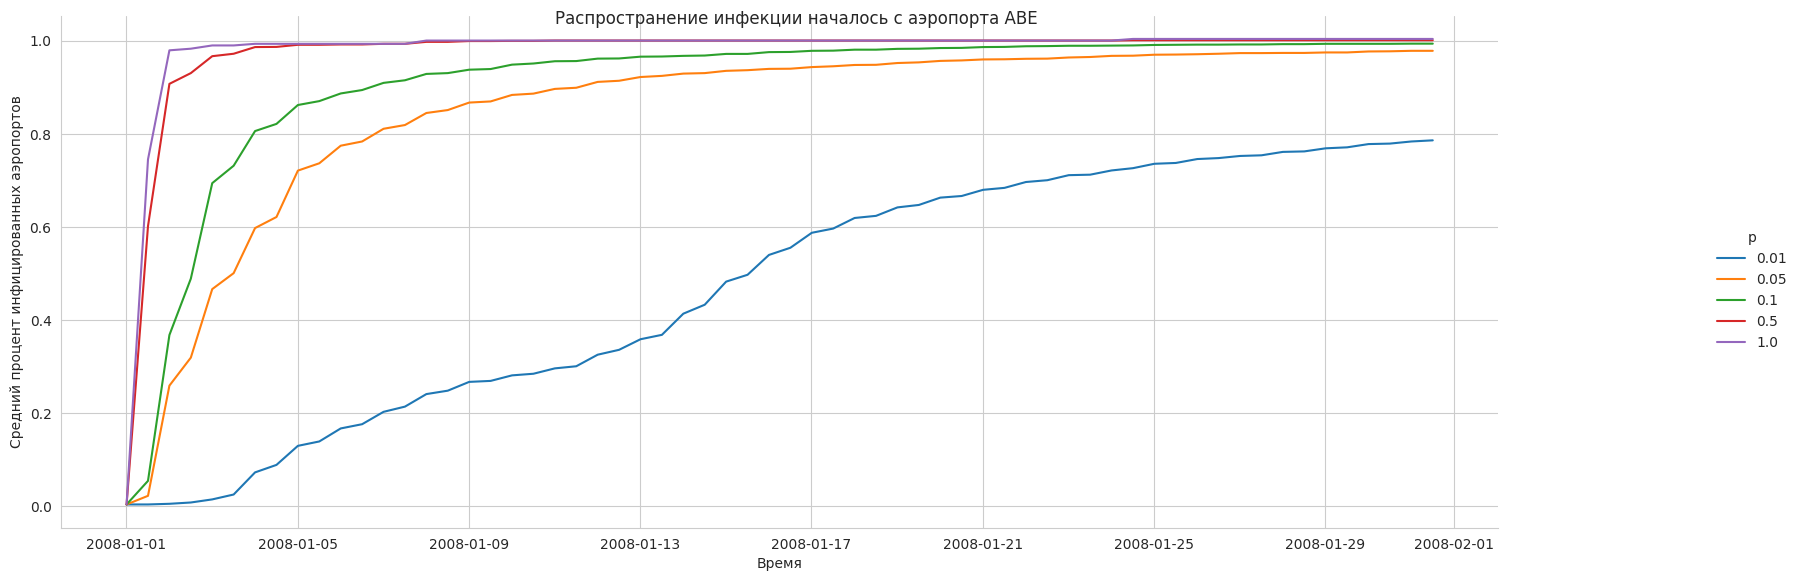

In [79]:
data_viz = pd.DataFrame.from_dict(time_sim_res, orient='index')
data_viz = data_viz.reset_index().melt(id_vars='index', var_name='p')
data_viz['p'] = data_viz.p.astype('category')

sns.set_style('whitegrid')
lp = sns.relplot(data=data_viz, kind='line', x='index', y='value', hue='p')
lp.fig.set_figwidth(20)
lp.fig.set_figheight(6)
lp.fig.suptitle(f'Распространение инфекции началось с аэропорта {airport}')
lp.ax.set_xlabel('Время')
lp.ax.set_ylabel('Средний процент инфицированных аэропортов')
plt.show()

# 4. Может ли информация о сети помочь предсказать, кто будет заражен?

In [81]:
@np.vectorize
def get_edge(origin, dest):

    # Функция для создания рёбер графа

    if origin < dest:
        result = f'{origin} {dest}'
    else:
        result = f'{dest} {origin}'
    return result

In [82]:
# Число рейсов
nf = data.shape[0]

# Создаём список рёбер из датафрейма
data['edge'] = get_edge(data.Origin, data.Dest)
edgelist = data.groupby('edge').size()/nf
edgelist = edgelist.reset_index()
edgelist[['node1', 'node2']] = edgelist['edge'].str.split(' ', 1, expand=True)
edgelist = edgelist[['node1', 'node2', 0]]
edgelist.columns = ['node1', 'node2', 'weight']
edgelist.to_csv('edgelist.csv', header=False, index=False, sep=' ')
edgelist

,node1,node2,weight
0,ABE,ATL,0.000256
1,ABE,CLE,0.000249
2,ABE,CLT,0.000102
3,ABE,CVG,0.000088
4,ABE,DTW,0.000281
...,...,...,...
2381,SRQ,STL,0.000051
2382,STL,TPA,0.000301
2383,STL,TUL,0.000193
2384,SUN,TWF,0.000002


In [83]:
# Создаем граф с помощью Networkx

In [84]:
graph = nx.read_weighted_edgelist('edgelist.csv', nodetype=str)
print(graph.number_of_nodes(), 'nodes and ', graph.number_of_edges(), 'edges in the graph')

287 nodes and  2386 edges in the graph


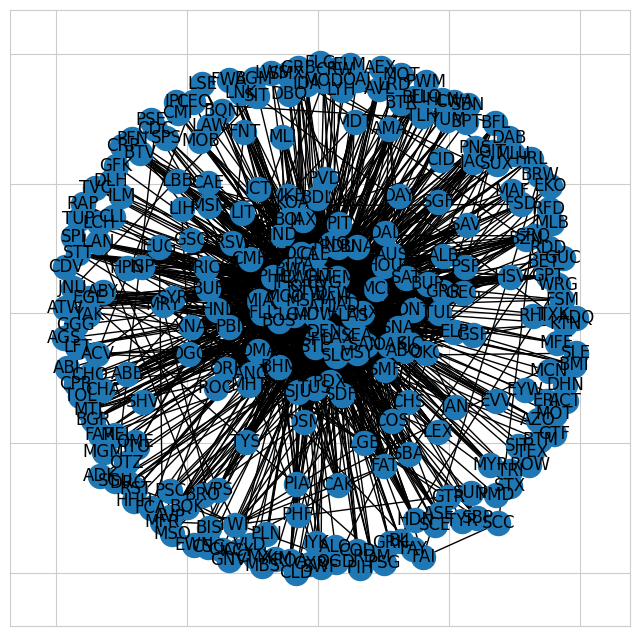

In [86]:
fig = plt.figure(1, figsize=(8, 8))
nx.draw_networkx(graph)

Для каждого города посчитаем его коэффициент кластеризации (nx.clustering), степень (nx.degree) и центральность (nx.betweenness_centrality)

In [87]:
clustering = nx.clustering(graph, weight='weight')
degree = dict(graph.degree(weight='weight'))
centrality = nx.betweenness_centrality(graph, weight='weight')

In [88]:
# Соберём все метрики в DataFrame
node_metrics = pd.DataFrame.from_dict(clustering ,orient='index', columns=['clustering']).join([
    pd.DataFrame.from_dict(degree ,orient='index', columns=['degree']),
    pd.DataFrame.from_dict(centrality ,orient='index', columns=['centrality'])
])
node_metrics.head()

,clustering,degree,centrality
ABE,0.049903,0.001369,0.029948
ATL,0.020622,0.111910,0.294541
CLE,0.038499,0.017384,0.046392
CLT,0.050012,0.035487,0.090677
CVG,0.025034,0.028621,0.064974


In [89]:
node_metrics.describe()

,clustering,degree,centrality
count,287.000000,287.000000,287.000000
mean,0.053468,0.006969,0.021629
std,0.040641,0.014471,0.053136
min,0.000000,0.000002,0.000000
25%,0.019501,0.000490,0.000000
50%,0.055466,0.001328,0.000000
75%,0.077552,0.004990,0.011900
max,0.237713,0.111910,0.406803


In [90]:
# Прогоним симуляцию 50 раз, используя p=0.5 и стартовый аэропорт Allentown (ABE)

In [91]:
# Сохраняем результаты симуляции results_50 в двоичном формате с использованием метода to_pickle в файл с именем 'sim50res.pkl'
# в компактной, сериализованной форме, что позволть быстро загружать и восстанавливать данные для дальнейшего использования без потери типов данных
np.random.seed(42)
results_50 = run_simulations('ABE', [0.5], 50)
results_50.to_pickle('sim50res.pkl')

Simulation for p = 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [92]:
results_50 = results_50.reset_index(drop=True)

# Время старта
start_t = results_50.loc[0, 'infected']
print(start_t)

# Подсчёт времени до инфицирования
results_50['dt'] = results_50['infected'] - start_t

# Подсчёт среднего времени
median_time = results_50.groupby('airport')['dt'].median()
assert median_time.isna().sum() == 0

2008-01-01 00:00:00


In [93]:
# Объединим медианное время с node metrics
ap_metrics = node_metrics.join(median_time)

# Конвертируем timedelta в часы
ap_metrics['hours'] = ap_metrics['dt'].dt.seconds/60/60
ap_metrics.head()

,clustering,degree,centrality,dt,hours
ABE,0.049903,0.001369,0.029948,0 days 00:00:00,0.000000
ATL,0.020622,0.111910,0.294541,0 days 10:11:00,10.183333
CLE,0.038499,0.017384,0.046392,0 days 10:21:30,10.358333
CLT,0.050012,0.035487,0.090677,0 days 08:47:00,8.783333
CVG,0.025034,0.028621,0.064974,0 days 10:00:00,10.000000


# 5. Визуализация и интерпретация результатов
Построим scatter-plot-ы для медианного времени заражения и каждой из рассчитанных выше метрик. Также посчитаем коэффициент корреляции Спирмана между этими показателями и попробуем проинтерпретировать полученные результаты

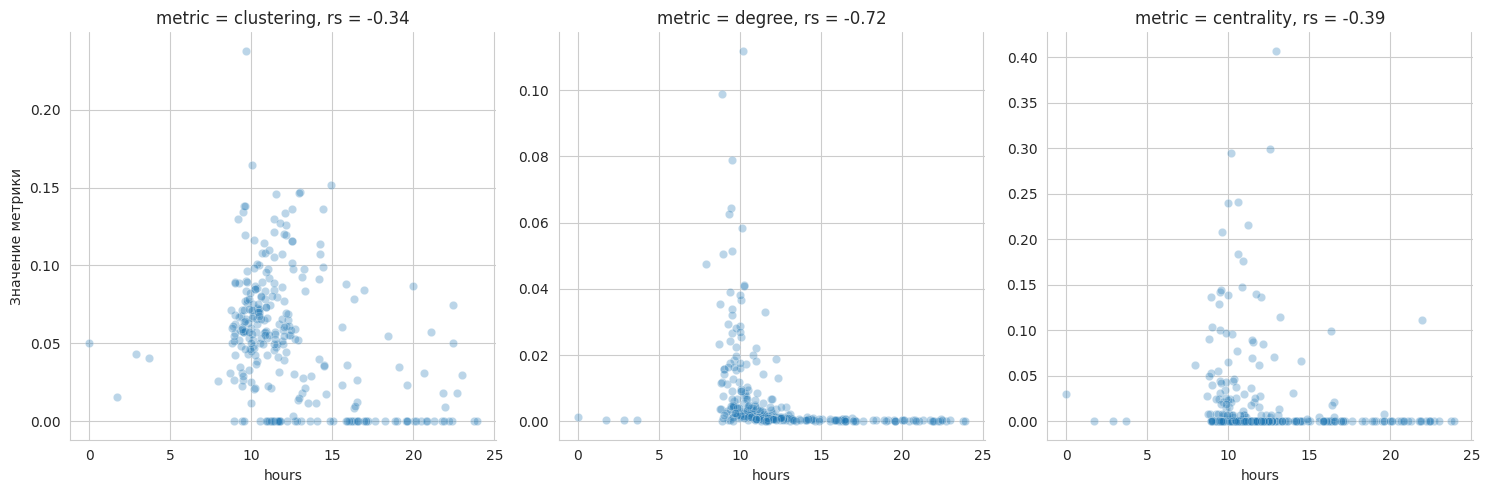

In [99]:
# Вычисление корреляции Спирмана
scorr = ap_metrics.drop('dt', axis=1).corr('spearman').loc['hours']

# Создание датафрейма для визуализации
visual_df = ap_metrics.drop('dt', axis=1).reset_index().melt(id_vars=['index', 'hours'], var_name='metric')

# Визуализация
sp = sns.relplot(data=visual_df, x='hours', y='value', col='metric', facet_kws={'sharey': False, 'sharex': True}, alpha=0.3)
sp.set_ylabels("Значение метрики")

axes = sp.fig.axes
for ax in axes:
    current_title = ax.get_title()
    metric_name = current_title.split(' ')[2]
    title = f'{current_title}, rs = {round(scorr[metric_name], 2)}'
    ax.set_title(title)
plt.show()

Коэффициент корреляции Спирмана между:

1) медианным временем заражения и  коэффициентом кластеризации, \
2) медианным временем заражения и коэффициентом степени, \
3) медианным временем заражения и коэффициентом центральности \
- везде показал слабую отрицательную корреляцию.

Анализ коэффициента корреляции Спирмана между этими показателями и медианным временем заражения может помочь понять, какие характеристики сети аэропортов могут повлиять на скорость распространения инфекции:\
1) инфекция распространяется быстрее, чем ближе контакт. \
2) аэропорты с более высоким временем заражения имеют меньшую связность по сравнению с аэропортами с меньшим временем заражения. \
3)аэропорты с центральным положением в сети имеют более низкие значения медианного времени заражения (заражаются быстрее). Это означает, что центральные узлы играют важную роль в распространении инфекции через сеть аэропортов.